In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#### 1. Write a program to integrate the following stochastic differential equation,
$$
dx = -xdt + \sqrt{2}dW.
$$
Use Euler integrator (replace $dt$ with $\Delta t$ and $dW$ with $\sqrt{\Delta t}R$, where $R$ is a Gaussian number with zero average and unitary variance; choose a short timestep $\Delta t=0.001$). To generate Gaussian numbers, you can copy the gasdev routine from `simplemd`. 

```
Answer:
def run(*,nsteps=1000,x0=10,seedval): # place asterisk so arguments can be passed
    x=x0
    dt=0.001
    traj=[]
    np.random.seed(seedval)
    for istep in range(nsteps)
        x+=-x*dt+np.sqrt(2*dt)*np.random.normal()
        traj.append(x)
    traj = np.array(traj)
```

In [27]:
def run_sde(nsteps=10000,delta_t=0.001,x0=10,seedval=42):
    '''
    nsteps - number of steps for calculation
    delta_t - time step
    x0 - initial position
    seedval - seed needed for prng routines
    '''
    x = x0
    traj = []
    np.random.seed(seedval)
    for istep in range(nsteps):
        r = np.random.standard_normal()
        x += -x * delta_t + np.sqrt(delta_t * 2) * r
        traj.append((istep*delta_t,x))
    return np.array(traj).T

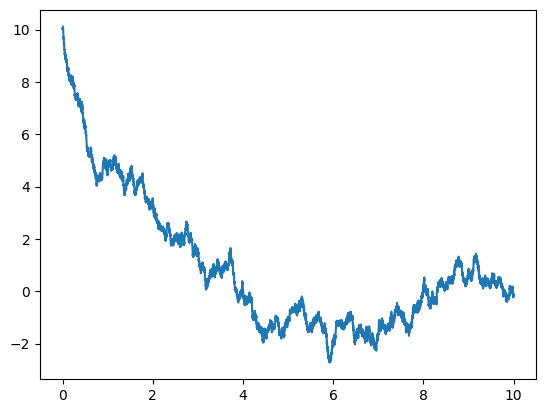

In [34]:
plt.plot(*run_sde())

#### 2. Using this program, compute $100$ trajectories with similar initial conditions $(x=10)$ and different seeds for the random number generator. 
At fixed value of time $t$, compute the average over the trajectories of the value of $x$ and its standard deviation. How do these two quantities depend on $t$?

Get all the samples, it becomes a deterministic process (you've already averaged over everything).

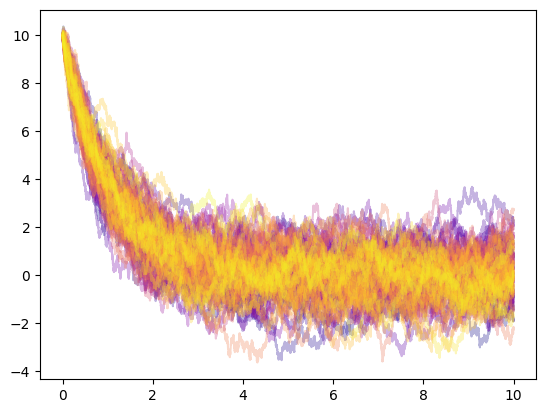

In [ ]:
trajlist = []
nsteps = 10000
tsteps = np.linspace(1,nsteps,nsteps) * 0.001 # also 0.001 * np.arange(10000)
for i in range(100):
    traj = run_sde(nsteps=nsteps,delta_t=0.001,x0=10,seedval=i)
    plt.plot(tsteps,traj[1],color=cm.plasma(i/100),alpha=0.3)
    trajlist.append(traj[1])
trajlist = np.array(trajlist)

In [37]:
means = np.mean(trajlist,axis=0)
stds = np.std(trajlist,axis=0)

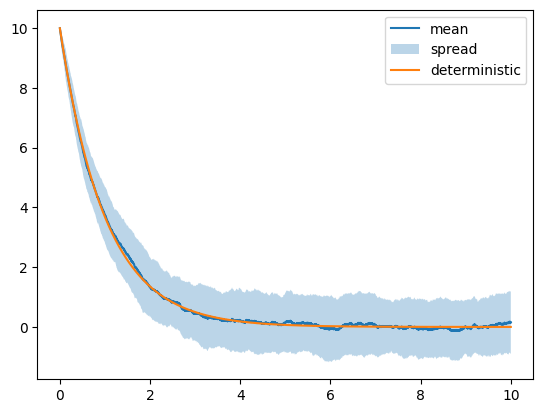

In [ ]:
# plt.plot(tsteps,trajlist[0],label='1st traj')
plt.plot(tsteps,means,label='mean')
plt.fill_between(tsteps,means-stds,means+stds,alpha=0.3,label='spread')
# plt.plot(tsteps)
plt.plot(tsteps,10*np.exp(-tsteps),label='deterministic')
plt.legend()

```
X=<x>

Y=<y>

dX=-X*dt

X(t)=x0*exp(-t)
```

```
dy = (2 - 2y)dt + ...
dy = 2 * (1 - y)dt

y(t) = C*exp(-2*t)+1
var(t) = Y(t) - X(t) * X(t)
= (x0**2-1)*exp(-2*t)+1 - x0**2 * exp(-2*t)
= 1-exp(-2*t)
```

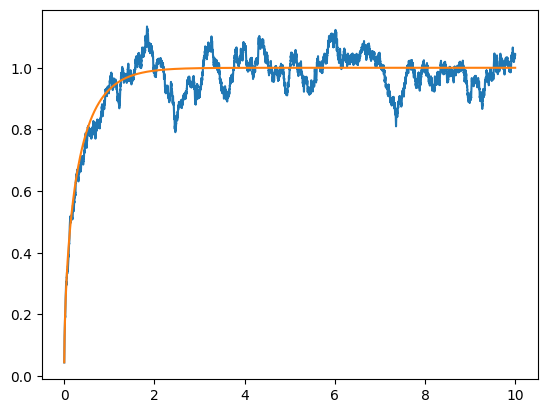

In [47]:
## Standard deviations
plt.plot(tsteps,stds)
plt.plot(tsteps,np.sqrt(-1*np.exp(-2*tsteps)+1)) # sqrt because standard deviation

#### 3. Use the Ito chain rule to derive the Equation of motion for the variable $y=x^2$ and implement the corresponding algorithm. 
Run multiple simulations on $x$ or $y$ with equivalent conditions. Notice that you should make sure $y$ stays positive while propagating it. A possible option is to reset $y$ to its absolute value at every step. Do the statistical properties of $x^2$ and $y^2$ match?

The Ito chain rule is given by,
$$
dy = (y'A + \frac{1}{2}y''B^2)dt + y'BdW.
$$

For the $y^2$ case (assuming the same values for $A$ and $B$ from above),
$$
dy = (2x(-x) + 2)dt + -2x\sqrt{2}dW \\
dy = 2(1-x^2)dt - 2\sqrt{2}xdW.
$$

Expressing the above equation purely in terms of $y$,
$$
dy = 2(1-y)dt - 2\sqrt{2y}dW.
$$

In [61]:
def yquad(x):
    return x**2

def run_itochain(nsteps=30000,delta_t=0.001,x0=10,seedval=42):
    x = x0
    y = yquad(x)
    traj = []
    # np.random.seed(seedval)
    for istep in range(nsteps):
        r = np.random.standard_normal()
        x += -x * delta_t + np.sqrt(delta_t * 2) * r
        y += 2 * (1 - y) * delta_t - 2 * np.sqrt(2 * y * delta_t) * r
        y = np.abs(y) # ensures y < 0
        traj.append((istep*delta_t,x,y))
    return np.array(traj).T

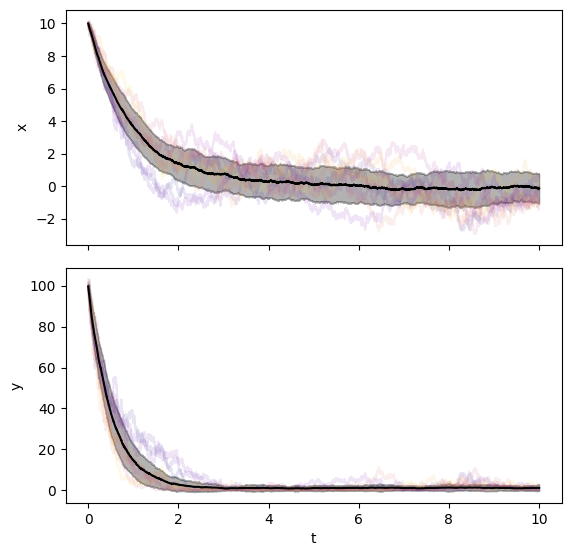

In [10]:
xtrajlist = []
ytrajlist = []
nsteps = 10000
tsteps = np.linspace(1,nsteps,nsteps) * 0.001
f,ax = plt.subplots(2,1,figsize=(6.4,6.4),sharex=True)
f.subplots_adjust(hspace=0.1)
for i in range(100):
    traj = run_itochain(nsteps=nsteps,delta_t=0.001,x0=10,seedval=i)
    if i%10==0:
        ax[0].plot(tsteps,traj[1],color=cm.plasma(i/100),alpha=0.1)
        ax[1].plot(tsteps,traj[2],color=cm.plasma(i/100),alpha=0.1)
    xtrajlist.append(traj[1])
    ytrajlist.append(traj[2])
ax[0].set_ylabel('x')
ax[1].set_ylabel('y')
ax[1].set_xlabel('t')
trajlist = np.array([xtrajlist,ytrajlist])

xmeans,ymeans = np.mean(trajlist,axis=1)
xstds,ystds = np.std(trajlist,axis=1)
ax[0].plot(tsteps,xmeans,color='k')
ax[1].plot(tsteps,ymeans,color='k')
ax[0].fill_between(tsteps,xmeans-xstds,xmeans+xstds,color='k',alpha=0.3)
ax[1].fill_between(tsteps,ymeans-ystds,ymeans+ystds,color='k',alpha=0.3)

In [59]:
def run_itochain_parallel(nsteps=30000,delta_t=0.001,x0=10,ntraj=1,seedval=42): # new edit - parallelized
    x = x0 * np.ones(ntraj)
    y = yquad(x)
    traj = []
    # np.random.seed(seedval)
    for istep in range(nsteps):
        r = np.random.standard_normal(size=ntraj)
        x += -x * delta_t + np.sqrt(delta_t * 2) * r
        y += 2 * (1 - y) * delta_t - 2 * np.sqrt(2 * y * delta_t) * r
        y = np.abs(y) # ensures y < 0; recheck discussion again on how y could be transiently 0
        # traj.append((istep*delta_t,x,y))
        traj.append((x.copy(),y.copy()))
    return np.array(traj).T

In [60]:
run_itochain_parallel(ntraj=100).shape

(100, 2, 30000)

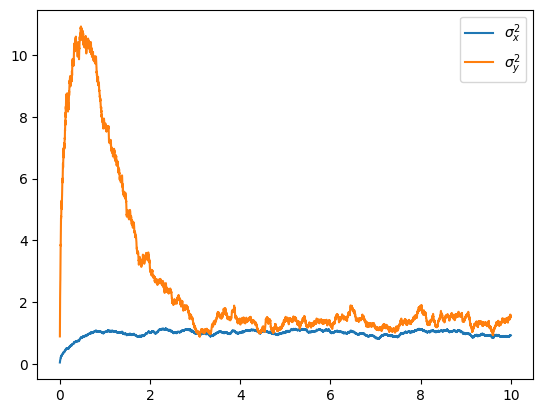

In [11]:
## Plotting deviations
plt.plot(tsteps,xstds,label=r'$\sigma_x^2$')
plt.plot(tsteps,ystds,label=r'$\sigma_y^2$')
plt.legend()

#### 4. Implement a code propagating $y$ using a naive chain rule (disregarding the Ito term $\frac{B^2y''}{2}dt$). 
Do the statistical property of this new set of trajectories match those obtained before? <code style="color: #ff79c6 "> No </code>

The naive chain rule would look like,
$$
dy = y'Adt + y'BdW \\
dy = -2x^2dt - 2\sqrt{2}xdW \\
dy = -2ydt - 2\sqrt{2y}dW.
$$

In [62]:
def run_naivechain(nsteps=30000,delta_t=0.001,x0=10,seedval=42):
    x = x0
    y = yquad(x)
    traj = []
    np.random.seed(seedval)
    for istep in range(nsteps):
        r = np.random.standard_normal()
        x += -x * delta_t + np.sqrt(delta_t * 2) * r
        y += -2 * y * delta_t - 2 * np.sqrt(2 * y * delta_t) * r
        y = np.abs(y) # ensures y < 0
        traj.append((istep*delta_t,x,y))
    return np.array(traj).T

In [63]:
ntrajlist = []
ytrajlist = []
nsteps = 10000
tsteps = np.linspace(1,nsteps,nsteps) * 0.001

for i in range(100):
    ntraj = run_naivechain(nsteps=nsteps,delta_t=0.001,x0=10,seedval=i)
    traj = run_itochain(nsteps=nsteps,delta_t=0.001,x0=10,seedval=i)
    ntrajlist.append(ntraj[2])
    ytrajlist.append(traj[2])
trajlist = np.array([ntrajlist,ytrajlist])


(0.0, 10.0)

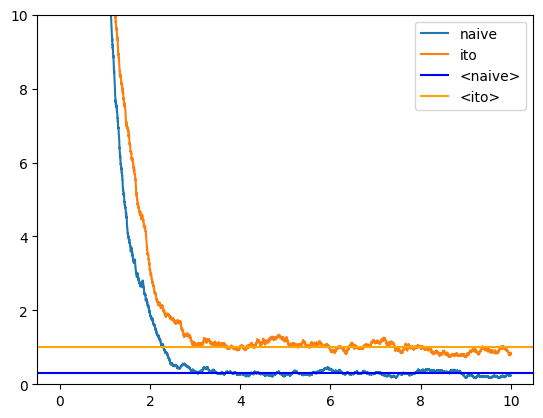

In [67]:
nmeans,ymeans = np.mean(trajlist,axis=1)
nstds,ystds = np.std(trajlist,axis=1)
# plt.plot(tsteps,ymeans-nmeans,label='<ito-naive>')
# plt.plot(tsteps,ystds-nstds,label='<ito**2>-<naive>**2')
plt.plot(tsteps,nmeans,label='naive')
plt.plot(tsteps,ymeans,label='ito')
plt.axhline(np.mean(nmeans[3000:]),color='blue',label='<naive>')
plt.axhline(np.mean(ymeans[3000:]),color='orange',label='<ito>')
# plt.fill_between(tsteps,nmeans-nstds,nmeans+nstds,alpha=0.3)
# plt.fill_between(tsteps,ymeans-ystds,ymeans+ystds,alpha=0.3)
plt.legend()
# plt.yscale('log')
plt.ylim(0,10)

Average will be lower for the naive chain because you have  

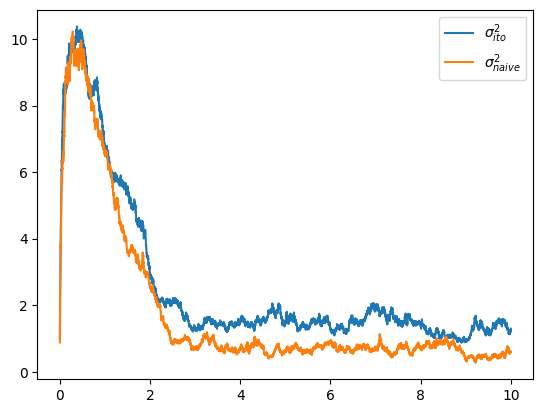

In [68]:
## Plotting deviations
plt.plot(tsteps,ystds,label=r'$\sigma^2_{ito}$')
plt.plot(tsteps,nstds,label=r'$\sigma^2_{naive}$')
plt.legend()


#### 5. Implement an implicit integrator for the equation obtained for $y$ at the previous point, where the prefactor for the Wiener noise is computed at the mid point as it is done in the Stratonovich formalism of stochastic differential equations. 

To do so you should iterate the solution at every step, until convergence is achieved within some numerical threshold. Do the statistical property of this new set of trajectories match those obtained before? <code style="color: #ff79c6 "> Not expecting things to be different because B is a constant. </code>

The Stratonovich chain rule has the following form,
$$
dy = \tilde{A}dt + \frac{1}{2}\tilde{B}\tilde{B}'dt + \tilde{B}dW,
$$
where $\tilde{B}=y'B$, $B$ being the Ito coefficient. Since $y = x^2$, $\tilde{B} = 2xB$.

In [69]:
def run_stratonovich(nsteps=30000,delta_t=0.001,x0=10,seedval=42):
    x = x0
    y = yquad(x)
    traj = []
    np.random.seed(seedval)
    for istep in range(nsteps):
        r = np.random.standard_normal()
        # x integrator; should be Stratonovich
        delta_x = -x * delta_t + np.sqrt(delta_t * 2) * r
        delta_xnew = -(x + 0.5 * delta_x) * delta_t + np.sqrt(delta_t * 2) * r # midpoint calculation 
        while delta_xnew - delta_x >= 1e-6:
            delta_x = delta_xnew
            delta_xnew = -(x + 0.5 * delta_x) * delta_t + np.sqrt(delta_t * 2) * r
        x += delta_xnew
        # y integrator 
        # y += -2 * y * delta_t - 2 * np.sqrt(2 * y * delta_t) * r # not this one maybe
        y += -2 * x * delta_t + 0.5 * 2 * 2 * delta_t + 2 * x * np.sqrt(2 * delta_t)
        y = np.abs(y) # ensures y < 0
        traj.append((istep*delta_t,x,y))
    return np.array(traj).T

In [70]:
ito_trajlist = []
strat_trajlist = []
nsteps = 10000
tsteps = np.linspace(1,nsteps,nsteps) * 0.001

for i in range(100):
    ito_traj = run_itochain(nsteps=nsteps,delta_t=0.001,x0=10,seedval=i)
    strat_traj = run_stratonovich(nsteps=nsteps,delta_t=0.001,x0=10,seedval=i)
    strat_trajlist.append(strat_traj[1])
    ito_trajlist.append(ito_traj[1])

In [71]:
ito_trajlist = np.array(ito_trajlist)
strat_trajlist = np.array(strat_trajlist)

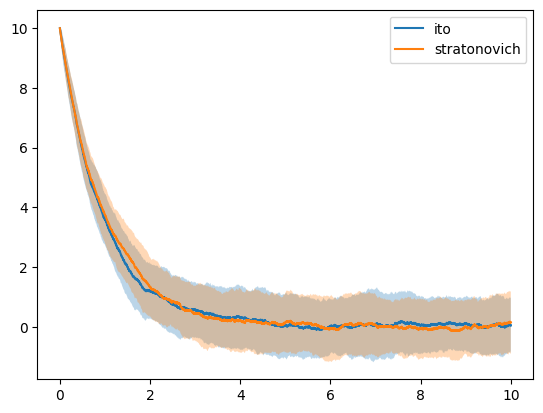

In [72]:
imeans = np.mean(ito_trajlist,axis=0)
istds = np.std(ito_trajlist,axis=0)
smeans = np.mean(strat_trajlist,axis=0)
sstds = np.std(strat_trajlist,axis=0)

# Difference plotting
# plt.plot(tsteps,imeans-smeans,label='<ito>-<strat>')
# plt.plot(tsteps,istds-sstds,label='<ito**2>-<strat>**2')

## Absolute plotting 
plt.plot(tsteps,imeans,label='ito')
plt.plot(tsteps,smeans,label='stratonovich')
plt.fill_between(tsteps,imeans-istds,imeans+istds,alpha=0.3)
plt.fill_between(tsteps,smeans-sstds,smeans+sstds,alpha=0.3)
plt.legend()
# plt.yscale('log')

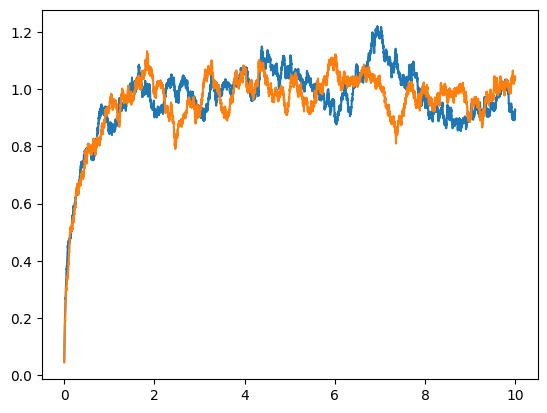

In [73]:
## Deviation plotting
plt.plot(tsteps,istds,label=r'$\sigma_{ito}^2$')
plt.plot(tsteps,sstds,label=r'$\sigma_{strat}^2$')

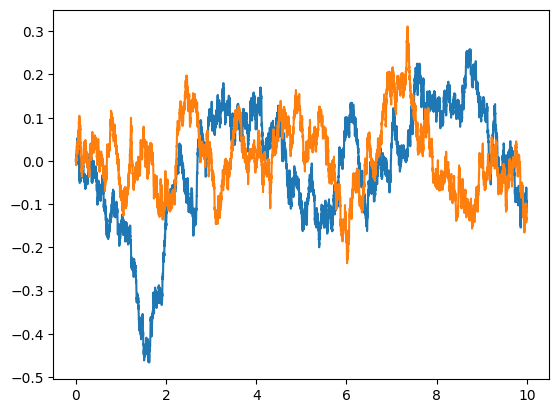

In [74]:
# Difference plotting
plt.plot(tsteps,imeans-smeans,label='<ito>-<strat>')
plt.plot(tsteps,istds-sstds,label='<ito**2>-<strat>**2')

#### Correct for #5

In [111]:
def run_y_stratonovich(*,nsteps=1000,x0=10,seed=42,ntrajs=1,eps=1e-8): # vectorized 
    dt=0.001
    y=x0**2*np.ones(ntrajs)
    traj=[]
    np.random.seed(seed)
    for istep in range(nsteps):
        ynew0=y.copy()
        ynew1=y.copy()
        rnd=np.random.normal(size=ntrajs)
        while True:
            ymid = 0.5 * (y + ynew0)
            # ymid = ynew0
            ynew1=np.abs(y-2*ymid*dt+np.sqrt(8*ymid*dt)*rnd)
            # ynew1=np.abs(y-2*y*dt+np.sqrt(8*(y+ynew0)/2*dt)*rnd) # abs here; can also recompute A here (no Ito term here, but won't change results)
            if np.sum((ynew1-ynew0)**2) < eps:
                break
            ynew0=ynew1
        y=ynew1
        traj.append(y.copy())    
    return np.array(traj).T

In [112]:
%%time
trajs = run_y_stratonovich(nsteps=10000,ntrajs=1000)

CPU times: user 1.89 s, sys: 20.9 ms, total: 1.91 s
Wall time: 1.91 s


In [98]:
%%time
ns = 10000
time = 0.001 * np.arange(ns)
trajs = run_y_stratonovich(nsteps=ns,ntrajs=1000)


CPU times: user 3.93 s, sys: 15.8 ms, total: 3.95 s
Wall time: 3.97 s


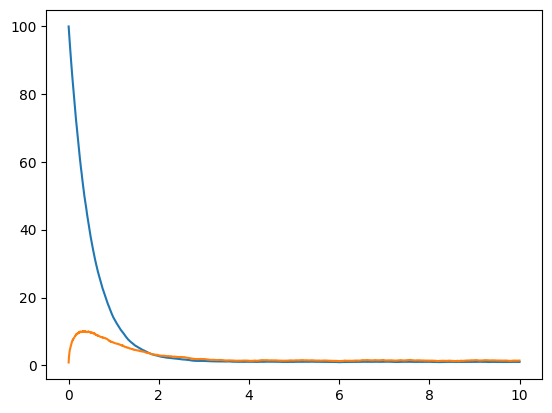

In [100]:
plt.plot(time,np.mean(trajs,axis=0))
plt.plot(time,np.std(trajs,axis=0))